In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display
from PIL import Image
import math

In [3]:
def detect_and_match_keypoints(img1, img2):
    """Detects and matches keypoints between two images using SIFT & BFMatcher."""
    sift = cv2.SIFT_create()

    # Convert to grayscale
    gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

    # Detect keypoints and descriptors
    keypoints1, descriptors1 = sift.detectAndCompute(gray1, None)
    keypoints2, descriptors2 = sift.detectAndCompute(gray2, None)

    # Brute-Force Matcher
    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
    matches = bf.match(descriptors1, descriptors2)

    # Sort matches by distance (best first)
    matches = sorted(matches, key=lambda x: x.distance)

    return keypoints1, keypoints2, matches

In [5]:
def get_homography(img1, img2):
    """Finds homography matrix to align img1 with img2."""
    keypoints1, keypoints2, matches = detect_and_match_keypoints(img1, img2)

    if len(matches) < 10:
        raise ValueError("Not enough matches found to compute homography.")

    # Extract point coordinates from matches
    src_pts = np.float32([keypoints1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([keypoints2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)

    # Compute homography matrix
    H, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

    return H


In [7]:
def stitch_two_images(img1, img2):
    """Warps img1 to align with img2 and blends them."""
    H = get_homography(img1, img2)

    # Get image dimensions
    height1, width1 = img1.shape[:2]
    height2, width2 = img2.shape[:2]

    # Warp img1
    warped_img1 = cv2.warpPerspective(img1, H, (width1 + width2, max(height1, height2)))

    # Blending - Add img2 on top without shape mismatch
    mask = (img2 > 0).astype(np.uint8)  # Create mask where img2 exists
    warped_img1[:height2, :width2] = warped_img1[:height2, :width2] * (1 - mask) + img2 * mask

    return warped_img1


In [9]:
def stitch_three_images(img1, img2, img3):
    """Stitches three images into one panorama."""
    stitched_1_2 = stitch_two_images(img1, img2)  # Stitch first two images
    panorama = stitch_two_images(stitched_1_2, img3)  # Add third image

    return panorama


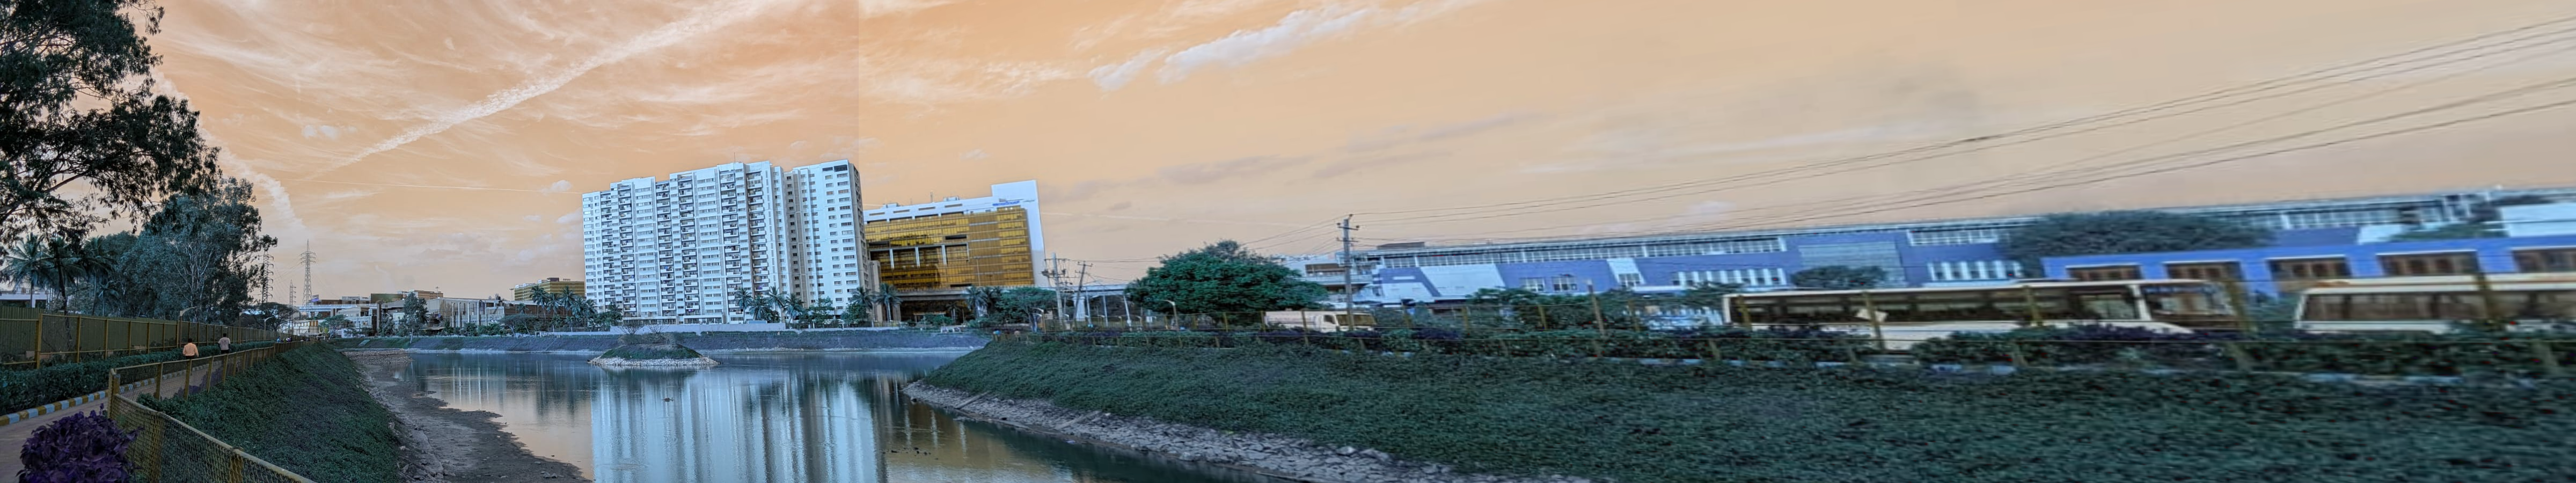

True

In [11]:
img1 = cv2.imread("Image1.jpeg")
img2 = cv2.imread("Image2.jpeg")
img3 = cv2.imread("Image3.jpeg")

if img1 is None or img2 is None or img3 is None:
    print("Error: One or more images could not be loaded.")
    exit()

# Stitch all three images
final_panorama = stitch_three_images(img1, img2, img3)

# Show and save the final panorama
display(Image.fromarray(final_panorama))
cv2.imwrite("panorama_output.jpg", final_panorama)